# Testing nested sampling for simulated signals offset in right ascension

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code running using a Reduced Order Quadrature (ROQ) to small offsets in right ascension. Here I run the code over a small range in right ascension, but with a signal that has been re-heterodyned to offset the true right ascension by varying amounts. This should show up the bug in the old code's phase sign for offset signals.

In [1]:
# import required modules
%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
import subprocess as sp
import os
import sys
import gzip
from time import time
import h5py

from scotchcorner import scotchcorner
from matplotlib import pyplot as pl

# these modules require lalapps
from lalapps.pulsarpputils import *
import lalpulsar

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

In [2]:
# set up the run directories
rundir = 'racheck'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detectors = ['H1', 'L1']        # the detectors to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadirs = []
for detector in detectors:
    datadir = os.path.join(rundir, 'data'+detector)
    if not os.path.isdir(datadir): # make the directory
        os.makedirs(datadir)
    datadirs.append(datadir)
    
# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O1' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested') # nested sampling code
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')         # original parameter estimation code
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
hetexec = os.path.join(execpath, 'lalapps_heterodyne_pulsar')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. The prior file adds frequency `F0` and first frequency derivative `F1` parameters and assumes Gaussian prior distributions on these.

I output a comparison plot between the posteriors produced with and without the ROQ. I compare the upper limits, evidences and maximum likelihoods produced by each method. I also compare the run times for each implementation of the code.

In [3]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {} {}
DECJ {}
F0 54.32
F1 -1.23e-11
PEPOCH 56789.0
EPHEM DE405
UNITS TDB
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 1125969920  # GPS start time of data (over a year after the pulsar period epoch)
duration = 86400*2     # duration of data (seconds) - 2 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(sigma**2/dlen)

# create the signal
pardict = {}
pardict['h0'] = sigma     # signal amplitude 
pardict['psi'] = 0.7      # random polarisation angle
pardict['cosiota'] = 0.1  # inclination angle
pardict['phi0'] = 1.0     # initial phase

# create a sky position
pardict['ra'] = 0.0
pardict['dec'] = 0.0

# covert RA and DEC to dd:mm:ss.s format
rah, ram, ras = rad_to_hms(pardict['ra'])
decd, decm, decs = rad_to_dms(pardict['dec'])

# set the required SNR of the signal
snr = 10.
snrind = 10./np.sqrt(2.) # individual detector SNR

In [4]:
# generate the signal
sigs = []
snropt = 0.
for detector in detectors:
    tssig, sig = heterodyned_pulsar_signal(gpsstart, duration, dt, detector, pardict)
    sigs.append(sig[0])
    # calculate SNR
    snropt += (get_optimal_snr(sig[0], sigma))**2
    
# calculate multi-detector SNR
snropt = np.sqrt(snropt)

# scale signal to required SNR
for sig in sigs:
    sig = sig*(snrind/snropt)

h0true = sigma*(snrind/snropt) # the new h0 value

In [5]:
# create set of right ascension offsets (in arcseconds)
raoffsets = [0., 1.0, 5.0, 10.0]
rasigma = 10.0

# create original (un-offset) data
datafiles = []
for i, sig in enumerate(sigs):
    data = sigma*np.random.randn(dlen, 2)

    # add signal to data
    data[:,0] = data[:,0] + sig.real
    data[:,1] = data[:,1] + sig.imag

    # append times and data together
    tad = np.vstack((gpstimes, data.T)).T

    # output fake data
    datafile = os.path.join(datadirs[i], 'finehet_'+psrname+'_'+detectors[i])
    np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    datafiles.append(datafile)

# output "true" .par
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), "1 %.12f" % rasigma, coord_to_string(decd, decm, decs)))
fp.close()

# create segment file
segfile = os.path.join(datadirs[0], 'segments.txt')
fp = open(segfile, 'w')
fp.write('%d %d\n' % (int(gpsstart), int(gpsstart+duration)))
fp.close()

# create offset heterodyne par file(s) and re-heterodyne with offset
parfileoffs = [parfile]
datafileoffs = [datafiles]
for i, raoff in enumerate(raoffsets[1:]):
    parfileoff = os.path.join(rundir, 'pulsar_offset_%02d.par' % i)
    parfileoffs.append(parfileoff)
    fp = open(parfileoff, 'w')
    fp.write(pardat.format(coord_to_string(rah, ram, ras+raoff), "1 %.12f" % rasigma, coord_to_string(decd, decm, decs)))
    fp.close()

    datafileoffd = []
    for j, detector in enumerate(detectors):
        datafilet = os.path.join(datadirs[j], 'finehet_%s_%02d_%s' % (psrname, i, detectors[j]))
        datafileoffd.append(datafilet)

        # run lalapps_heterodyne_pulsar to re-heterodyne the signal with an offset frequency
        codecall = ' '.join([hetexec, '-i', detector, '-p', psrname, '-z', '4', '-f', parfile, '-g', parfileoff,
                    '-e', '/opt/lscsoft/share/lalpulsar/earth00-19-DE405.dat.gz',
                    '-S', '/opt/lscsoft/share/lalpulsar/sun00-19-DE405.dat.gz',
                    '-t', '/opt/lscsoft/share/lalpulsar/tdb_2000-2019.dat.gz',
                    '-s', '1', '-r', '1', '-d', datafiles[j], '-o', datafilet, '-l', segfile])

        p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
        out, err = p.communicate()
        
        # strip the header comments (starting with a %) out of the file as lalapps_pulsar_parameter_estimation can't parse them
        codecall = ' '.join(['sed', '-i', "'/^%/d'", datafilet])
        p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
        out, err = p.communicate()

    datafileoffs.append(datafileoffd)

In [6]:
# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '400' # number of nested sample live points

# ROQ setup
ntraining = '2500'     # the number of training models to form the reduced basis
roqtolerance = '5e-12' # the maximum allowed residuals between the training set and reduced basis
h0ulnest = []

priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform 0 {}
COSIOTA uniform -1 1
RA gaussian {:.12f} {:.1e}
"""

for i, df in enumerate(datafileoffs):
    # upper range of prior
    h0max = h0true + ulest*6.

    priorfile = os.path.join(rundir, 'pulsar.prior')
    fp = open(priorfile, 'w')
    fp.write(priordat.format(h0max, np.pi, np.pi/2., pardict['ra']+2.*np.pi*(raoffsets[i]/(60.*60.*24)), 2.*np.pi*rasigma/(60.*60.*24.)))
    fp.close()

    # run lalapps_pulsar_parameter_estimation using the ROQ
    codecall = ' '.join([ppenexec, '--detectors', ','.join(detectors),
                         '--par-file', parfileoffs[i], '--prior-file', priorfile,
                         '--input-files', ','.join(df), '--outfile', os.path.join(outdir, 'fake_nest_roq_%02d.hdf' % i),
                         '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--roq-tolerance',
                         roqtolerance, '--ntraining', ntraining, '--chunk-max', '1440'])

    p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # nested samples need to be converted to posterior samples with lalapps_nest2pos
    if os.path.isfile(os.path.join(outdir, 'fake_post_roq_%02d.hdf' % i)):
        os.remove(os.path.join(outdir, 'fake_post_roq_%02d.hdf' % i))
    codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post_roq_%02d.hdf' % i),
                         os.path.join(outdir, 'fake_nest_roq_%02d.hdf' % i)])
    p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # get h0 upper limit
    postroq, evsigroq, evnoiseroq = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_roq_%02d.hdf' % i))
    h0ulnest.append(upper_limit_greedy(postroq['h0'].samples, upperlimit=0.95))

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'F1', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'F1', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PH

Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'F1', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F0', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'F1', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'H0', 'PH

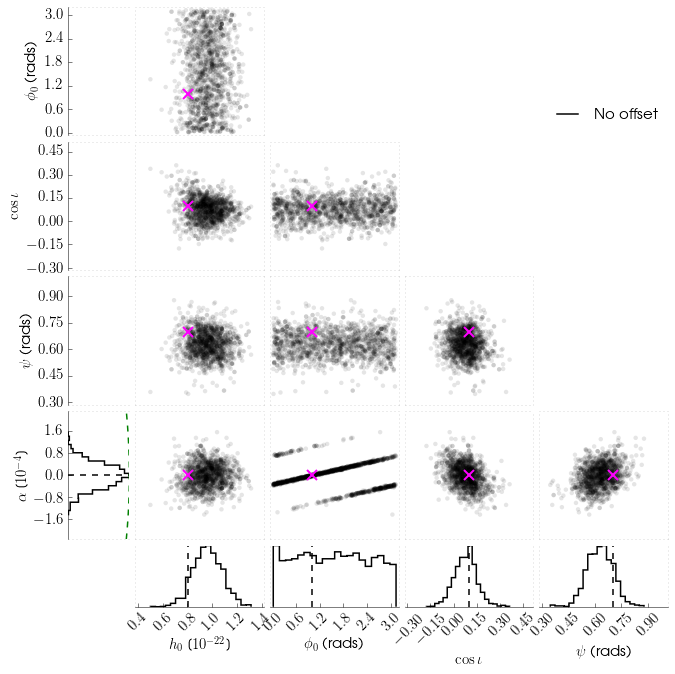

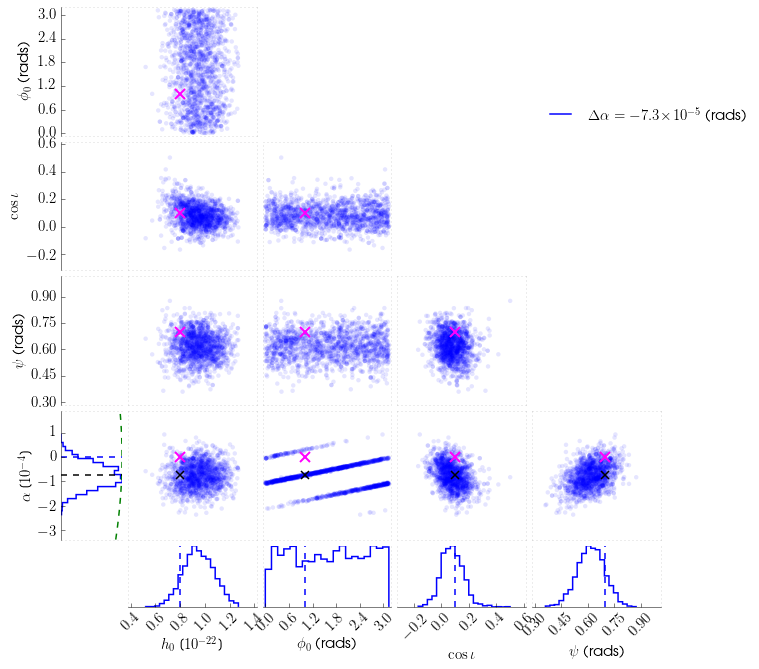

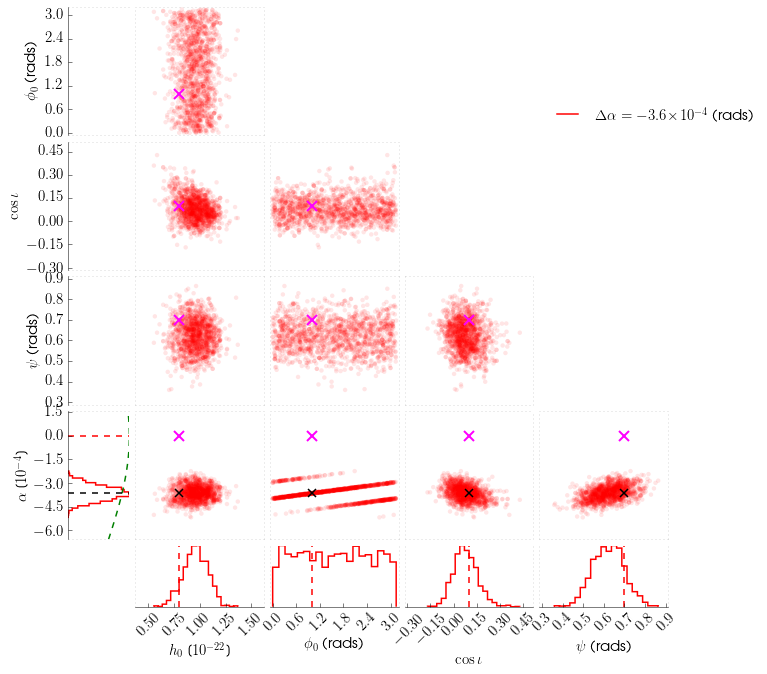

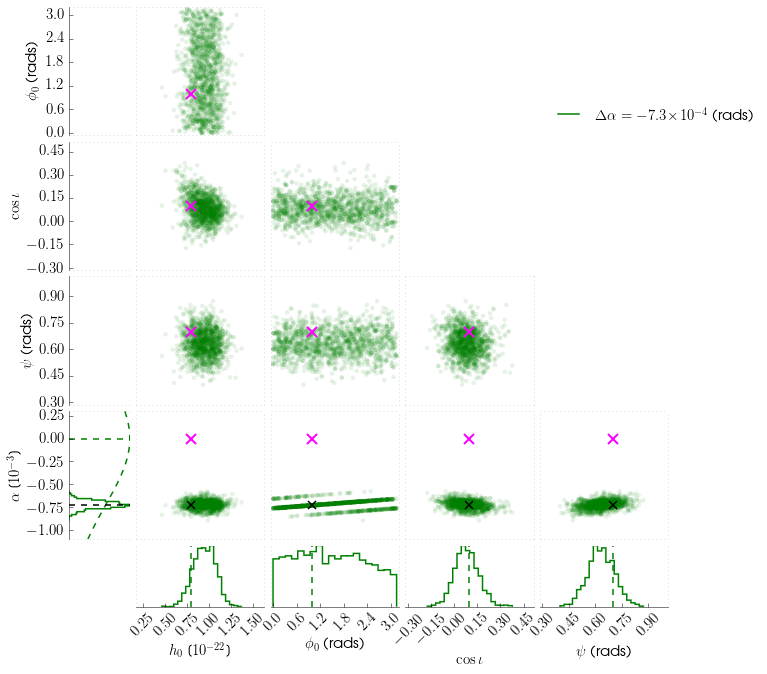

In [7]:
from scipy.stats import norm

def exp_str(f, p=1, otype='html'):
    s = '%.16e' % f
    ssplit = s.split('e')
    return '\\ensuremath{%.*f\!\\times\!10^{%d}}'  % (p, float(ssplit[0]), int(ssplit[1]))

params = ['h0', 'phi0', 'cosiota', 'psi', 'ra']

labels = ['$h_0$', '$\phi_0$ (rads)', '$\cos{\iota}$', '$\psi$ (rads)', '$\\alpha$']
limits = [(0., None), (0., np.pi), (-1., 1.), (0., np.pi/2.),  (None, None)]
subtract_truths = [4]

colors = ['black', 'blue', 'red', 'green']

titles = ['No offset']
for raoff in raoffsets[1:]:
    titles.append('$\Delta \\alpha = -$'+exp_str(raoff*2.*np.pi/(24.*60.*60.))+' (rads)')

for i in range(len(raoffsets)):
    postroq, evsigroq, evnoiseroq = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_roq_%02d.hdf' % i))

    postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
    for j, p in enumerate(params):
        postppenroq[:,j] = postroq[p].samples[:,0]
    
    truths = [h0true, pardict['phi0'], pardict['cosiota'], pardict['psi'], pardict['ra']+raoffsets[i]*2.*np.pi/(24.*60.*60.)]

    #if i == 0:
    histops = {'histtype': 'step', 'color': colors[i], 'edgecolor': colors[i], 'linewidth': 1.5, 'alpha': 1.0}
    sc = scotchcorner(postppenroq, bins=20, ratio=2, labels=labels, datatitle=titles[i], showlims='both', hist_kwargs=histops,
                      showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                      truths_kwargs={'color': colors[i], 'markersize': 10, 'markeredgewidth': 2,
                      'markerfacecolor': 'magenta', 'markeredgecolor': 'magenta'}, subtract_truths=subtract_truths)
    #else:
    #    histops = {'histtype': 'step', 'color': colors[i], 'edgecolor': colors[i], 'linewidth': 1.5}
    #    sc.add_data(postppenroq, hist_kwargs=histops, showcontours=False, scatter_kwargs={'alpha': 0.1}, limits=limits,
    #               truths=truths)

    axra = sc.get_axis('$\\alpha$')
    rarange = np.linspace(axra.get_ylim()[0], axra.get_ylim()[1], 100)
    priorpdf = norm.pdf(rarange, 0., 2.*np.pi*(rasigma/(24.*60.*60)))
    priorpdf *= (axra.get_xlim()[1]/np.max(priorpdf))
    axra.plot(priorpdf, rarange, 'g--', lw=1.5)

    if i > 0:
        axra.axhline(-raoffsets[i]*2.*np.pi/(24.*60.*60.), color='k', linestyle='--', linewidth=1.5)
        
        for j, l in enumerate(labels):
            if l != '$\\alpha$':
                ax = sc.get_axis(l+'vs$\\alpha$')
                ax.plot(truths[j], -raoffsets[i]*2.*np.pi/(24.*60.*60.), color='k', marker='x', markeredgewidth=1.5,
                        markersize=8)

In [8]:
print(2.*np.pi*np.array(raoffsets)/(24.*60.*60))

[  0.00000000e+00   7.27220522e-05   3.63610261e-04   7.27220522e-04]
